In [7]:
import json
import os
from pathlib import Path
import sys
sys.path.append('..')
from mlm_utils.transform_func import encode_text


/home/phatpham/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-05-23 11:25:20.153597: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 11:25:20.676903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:25:22.171570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-23 11:25:24.396883: E tensorflow/compiler/xla/stream_executor/cuda/cu

### load finetuned model

In [3]:
import torch
import sys
sys.path.append('..')
from utils.data_utils import NLP_MODELS
from utils.task_utils import TasksParam
from SRL.model import multiTaskModel
model_file = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/output/multi_task_model_9_13050.pt')


def load_params(model_file):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Load finetuned model 
    loadedDict = torch.load(model_file, map_location=torch.device(device))
    
    taskParams = loadedDict['task_params']
   
    # tempTaskParams = TasksParam('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/SRL/tasks_file_SRL.yml')
    #transfering the names of file in new task file to loaded task params
    # for taskId, taskName in taskParams.taskIdNameMap.items():
       
    #     assert taskName in tempTaskParams.taskIdNameMap.values(), "task names changed in task file given.\
    #     tasks supported for loaded model are {}".format(list(taskParams.taskIdNameMap.values()))

    #     taskParams.fileNamesMap[taskName] = tempTaskParams.fileNamesMap[taskName]
    allParams = {}
    allParams['task_params'] = taskParams
    allParams['gpu'] = torch.cuda.is_available()
    
    # dummy values
    allParams['num_train_steps'] = 13050
    allParams['warmup_steps'] = 0
    allParams['learning_rate'] = 2e-05
    allParams['epsilon'] = 1e-8

    modelName = taskParams.modelType.name.lower()
    print("Model Name: ", modelName)
    _, _ , tokenizerClass, defaultName = NLP_MODELS[modelName]
    configName = taskParams.modelConfig
    if configName is None:
        configName = defaultName

    return allParams, loadedDict

a = load_params(model_file)
model = multiTaskModel(a[0])
model.load_multi_task_model(a[1])

Model Name:  bert


In [52]:
def convert_save_json(data, wriDir, write_file):
    def encode_sentence(sentence):
        encode_data = encode_text(sentence['avg_neg_cos'])
        feature = {'uid': sentence['origin_uid'], 
                    'token_id': encode_data['input_ids'][0].tolist(),
                    'type_id': encode_data['token_type_ids'][0].tolist(),
                    'mask': encode_data['attention_mask'][0].tolist(),
                    'pos_tag_id': sentence['pos_tag_id']
                    }
        return feature
    features = list(map(encode_sentence, data))
    
    with open(os.path.join(wriDir, write_file) , 'w') as f:
        for item in features:
            f.write('{}\n'.format(json.dumps(item)))
            
 
# function to split each file into train, dev, test, concatenate all train files into one file.
def split_train_dev_test(data, wriDir, write_file, type_file):
    def encode_sentence(sentence, type_file):
        encode_data = encode_text(sentence[type_file])
        feature = {'uid': sentence['origin_uid'], 
                    'token_id': encode_data['input_ids'][0].tolist(),
                    'type_id': encode_data['token_type_ids'][0].tolist(),
                    'mask': encode_data['attention_mask'][0].tolist(),
                    'pos_tag_id': sentence['pos_tag_id'],
                    'label': sentence['label']
                    }
        return feature
    features = list(map(lambda x: encode_sentence(x, type_file), data))
    # split data into train, dev, test: 60%, 20%, 20%
    train = features[:int(len(features)*0.6)]
    dev = features[int(len(features)*0.6):int(len(features)*0.8)]
    test = features[int(len(features)*0.8):]
    
    wrt_dev = 'dev_{}'.format(write_file)
    wrt_test = 'test_{}'.format(write_file)
    
    with open(os.path.join(wriDir, wrt_dev) , 'w') as f:
        for item in dev:
            f.write('{}\n'.format(json.dumps(item))) 
            
    with open(os.path.join(wriDir, wrt_test) , 'w') as f:
        for item in test:
            f.write('{}\n'.format(json.dumps(item)))          
    
    return train, dev, test

In [53]:
# read masked_data_text
from pathlib import Path
import os
dataDir = Path('./data_mlm/perturbed_data')
labelDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/MLM/data_mlm/process_folder/coNLL_tsv_json/modify_label_prepared_data')
def create_data_perturbation(dataDir, labelDir, type_file):
    train_data = []
    dev_data = []
    test_data = []
    dataMaskedDir = dataDir / Path('masked_data_text')
    
    wrtDir = dataDir / Path(type_file)
    # create directory if not exist
    if not os.path.exists(wrtDir):
        os.makedirs(wrtDir)
        
    for data_file, label_file in zip(os.listdir(dataMaskedDir), os.listdir(labelDir)):
        with open(os.path.join(dataMaskedDir, data_file), 'r') as f, open(os.path.join(labelDir, label_file), 'r') as f1:
            data = [json.loads(line) for line in f]  
            data_label = [json.loads(line) for line in f1]
            
            
            # check if origin uid is the same, then add label to data
            # Create a dictionary from data_label for quick lookup
            label_dict = {int(item['uid']): item['label'] for item in data_label}

            # assign label from data_label if uid matches
            for item in data:
                uid = item['origin_uid']
                
                if uid in label_dict:
                
                    item['label'] = label_dict[uid]
               
        data_splited = split_train_dev_test(data, wrtDir, data_file, type_file)
        train_data.extend(data_splited[0])
        dev_data.extend(data_splited[1])
        test_data.extend(data_splited[2])
    
    # write train data
    with open(os.path.join(wrtDir, 'train.json') , 'w') as f:
        for item in train_data:
            f.write('{}\n'.format(json.dumps(item)))
    
    # write dev data
    with open(os.path.join(wrtDir, 'dev.json') , 'w') as f:
        for item in dev_data:
            f.write('{}\n'.format(json.dumps(item)))
            
    # write test data
    with open(os.path.join(wrtDir, 'test.json') , 'w') as f:
        for item in test_data:
            f.write('{}\n'.format(json.dumps(item)))



In [54]:
type_files = ['sum_neg_cos', 'avg_neg_cos', 'sum_pos_cos', 'avg_pos_cos', 'sum_neg_cos_module', 'avg_neg_cos_module', 'sum_pos_cos_module', 'avg_pos_cos_module']
for type_file in type_files:
    print('Processing type file: ', type_file)
    create_data_perturbation(dataDir, labelDir, type_file)

Processing type file:  sum_neg_cos
Processing type file:  avg_neg_cos
Processing type file:  sum_pos_cos
Processing type file:  avg_pos_cos
Processing type file:  sum_neg_cos_module
Processing type file:  avg_neg_cos_module
Processing type file:  sum_pos_cos_module
Processing type file:  avg_pos_cos_module


### training srl with pertubed data

In [ ]:
!python ../train.py \
    --data_dir './data_mlm/perturbed_data/avg_neg_cos' \
    --task_file '../SRL/srl_perturbation.yml' \
    --out_dir './output_srl_perturb_data' \
    --epochs 10 \
    --train_batch_size 32 \
    --eval_batch_size 32 \
    --grad_accumulation_steps 1 \
    --log_per_updates 50 \
    --max_seq_len 85 \
    --eval_while_train \
    --test_while_train \
    --silent \
    

### get data mask


In [8]:

import numpy as np
import sys

import pandas as pd
sys.path.append('../')
from data_preparation import * 
from mlm_utils.pertured_dataset import PerturedDataset
import torch.nn as nn
import math
import os
import torch
from utils.eval_metrics import seqeval_f1_score
class DataMaker():
    def __init__(self, data_file, eval_batch_size=32, max_seq_len=85, seed=42):
        self.data_file = data_file
        
        self.eval_batch_size = eval_batch_size
        self.max_seq_len = max_seq_len
        self.seed = seed
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        assert os.path.exists(self.data_file), "prediction tsv file not present at {}".format(self.data_file)
        
        self.dataset = PerturedDataset(self.data_file, self.device)
        self.dataloader = self.dataset.generate_batches(self.dataset, self.eval_batch_size)
       
    def get_predictions(self, model):
        model.network.eval()
        
        allPreds = []
        allScores = []
        allLogitsSoftmax = []
        allLogitsRaw = []
        allLabels = []
        allOriginUIDs = []
        for batch in tqdm(self.dataloader, total = len(self.dataloader)):
            batch = tuple(t.to(self.device) if isinstance(t, torch.Tensor) else t for t in batch)

            origin_uid, token_id, type_id, mask, label, pos_tag_id = batch
            with torch.no_grad():
                _, logits = model.network(token_id, type_id, mask, 0, 'conllsrl')

               
                outLogitsSoftmax = nn.functional.softmax(logits, dim = 2).data.cpu().numpy()
                
                outLogitsSigmoid = nn.functional.sigmoid(logits).data.cpu().numpy()
                
                predicted_sm = np.argmax(outLogitsSoftmax, axis = 2)
                

                # here in score, we only want to give out the score of the class of tag, which is maximum
                predScore = np.max(outLogitsSigmoid, axis = 2).tolist() 
                
                predicted_sm = predicted_sm.tolist()
                
                # get the attention masks, we need to discard the predictions made for extra padding
                
                predictedTags = []
                predScoreTags = []
                
                if mask is not None:
                    #shape of attention Masks (batchSize, maxSeqLen)
                    actualLengths = mask.cpu().numpy().sum(axis = 1).tolist()
                
                    for i, (pred, sc) in enumerate(zip(predicted_sm, predScore)):
                        predictedTags.append( pred[:actualLengths[i]] )
                        predScoreTags.append( sc[:actualLengths[i]])
        
                else:
                    predictedTags = predicted_sm
                    predScoreTags = predScore
                
                allPreds.append(predictedTags)  
                allScores.append(predScoreTags)  
                allLogitsSoftmax.append(outLogitsSoftmax)
                allLabels.append(label.tolist())
                allLogitsRaw.append(logits.data.cpu().numpy())
                allOriginUIDs.append(origin_uid)
            
        allOriginUIDs = [item for sublist in allOriginUIDs for item in sublist]
        allPreds = [item for sublist in allPreds for item in sublist]
        allScores = [item for sublist in allScores for item in sublist]
        allLogitsSoftmax = [item for sublist in allLogitsSoftmax for item in sublist]
        allLogitsRaw = [item for sublist in allLogitsRaw for item in sublist]
        allLabels = [item for sublist in allLabels for item in sublist]

        return allOriginUIDs, allPreds, allScores, allLogitsSoftmax, allLogitsRaw, allLabels

  
    
    def evaluate(self, model, labMapRevN, wrtPredPath=None, wrtDir=None, returnPreds=True, hasTrueLabels=True, needMetrics=True):
        allOriginUIDs, allPreds, allScores, allLogitsSoftmax, allLogitsRaw, allLabels = self.get_predictions(model)
        
        for j, (p, l) in enumerate(zip(allPreds, allLabels)):
            allLabels[j] = l[:len(p)]
            allPreds[j] = [labMapRevN[int(ele)] for ele in p]
            allLabels[j] = [labMapRevN[int(ele)] for ele in allLabels[j]]
        #allPreds[i] = [ [ labMapRev[int(p)] for p in pp ] for pp in allPreds[i] ]
        #allLabels[i] = [ [labMapRev[int(l)] for l in ll] for ll in allLabels[i] ]

        newPreds = []
        newLabels = []
        newScores = []
        newLogitsSoftmax = []
        for m, samp in enumerate(allLabels):
            Preds = []
            Labels = []
            Scores = []
            LogitsSm = []
            for n, ele in enumerate(samp):
                #print(ele)
                if ele != '[CLS]' and ele != '[SEP]' and ele != 'X':
                  
                    Preds.append(allPreds[m][n])
                    Labels.append(ele)
                    Scores.append(allScores[m][n])
                    LogitsSm.append(allLogitsSoftmax[m][n])
                    
            newPreds.append(Preds)
            newLabels.append(Labels)
            newScores.append(Scores)
            newLogitsSoftmax.append(LogitsSm)
        
        allLabels = newLabels
        allPreds = newPreds
        allScores = newScores    
        allLogitsSoftmax = newLogitsSoftmax        
        
        if needMetrics:
        
            print("**********Evaluation************\n")
            
            metricVal = seqeval_f1_score(allLabels, allPreds)
            print("F1 Score: ", metricVal)
        
        # flatten allPreds, allScores
        if wrtPredPath is not None and wrtDir is not None:
            for i in range(len(allPreds)):
                if allPreds[i] == []:
                    continue
                if hasTrueLabels:
                    df = pd.DataFrame({"uid" : allOriginUIDs[i], "prediction" : allPreds[i], "label" : allLabels[i]})
                    savePath = os.path.join(wrtDir, "origin_{}".format(wrtPredPath))
                else:
                    df = pd.DataFrame({"uid" : allOriginUIDs[i], "prediction" : allPreds[i]})
                    savePath = os.path.join(wrtDir, "masked_{}".format(wrtPredPath))

            df.to_csv(savePath, sep = "\t", index = False)
        
        if returnPreds:
            return allOriginUIDs, allPreds, allScores, allLogitsSoftmax, allLogitsRaw, allLabels    

In [18]:
# import os
# from pathlib import Path
# from data_maker import DataMaker

dataMaker = DataMaker(
    data_file= os.path.join(dataMaskedDir,'avg_neg_cos_decrease_2.json')
)
wrtPredPath = 'prediction_decrease_2_full.tsv'
wrtDir = './mlm_prediction'
labelMap = a[0]['task_params'].labelMap['conllsrl']
labelMap = {v:k for k,v in labelMap.items()}

resultwordMasked  = dataMaker.evaluate(model, labelMap, wrtPredPath=wrtPredPath, wrtDir=wrtDir, returnPreds=True, hasTrueLabels=False, needMetrics=False)
resultwordMasked = {
    'uid': resultwordMasked[0],
    'pred': resultwordMasked[1],
    'score': resultwordMasked[2],
    'logitsSoftmax': resultwordMasked[3],
    'logitsRaw': resultwordMasked[4],
    'dummy_label': resultwordMasked[5] 
}

  0%|          | 0/17 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 17/17 [01:01<00:00,  3.62s/it]


In [6]:
labelMap = a[0]['task_params'].labelMap['conllsrl']
labelMap = {v:k for k,v in labelMap.items()}


In [9]:
dataOriginDir = Path('/mnt/c/Users/Phat Pham/Documents/THESIS/SRLPredictionEasel/data/coNLL_tsv/dmis-lab/biobert-base-cased-v1.2_prepared_data')
dataMaker = DataMaker(
    data_file= os.path.join(dataOriginDir,'ner_conll_testb_alter.json')
)

wrtPredPath = 'prediction_decrease_2_full.tsv'
wrtDir = './mlm_prediction'
resultwordOrigin  = dataMaker.evaluate(model, labelMap, wrtPredPath=wrtPredPath, wrtDir=wrtDir, returnPreds=True, hasTrueLabels=True, needMetrics=True)
resultwordOrigin = {
    'uid': resultwordOrigin[0],
    'pred': resultwordOrigin[1],
    'score': resultwordOrigin[2],
    'logitsSoftmax': resultwordOrigin[3],
    'logitsRaw': resultwordOrigin[4],
    'label': resultwordOrigin[5]  
}


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:14<00:00,  1.80s/it]

**********Evaluation************

F1 Score:  0.6805399325084365



/home/phatpham/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


In [20]:
import numpy as np
import torch

def get_idx_arg_preds(preds_origin, preds_masked, label_origin=None): # label_origin: nhãn gold
    list_idx_arg_change = []
 
    assert len(preds_origin) == len(preds_masked)
    for i in range(len(preds_masked)):
        test = preds_origin[i].startswith('B-A') or preds_origin[i].startswith('I-A') or preds_masked[i].startswith('B-A') or preds_masked[i].startswith('I-A')
        if label_origin:
            assert len(preds_origin) == len(label_origin), 'Length of preds_origin and label_origin must be the same'
            if test or label_origin[i].startswith('B-A') or label_origin[i].startswith('I-A'):
                list_idx_arg_change.append(i)
        else:
            if test:
                list_idx_arg_change.append(i)
   
    return list_idx_arg_change

def calculateInfluenceScore(outLogitsSigmoid_original, outLogitsSigmoid_meddle, list_arg_change):
    influence_score = []
    weight = []
    # assert len(outLogitsSigmoid_original) == len(outLogitsSigmoid_meddle) 
    for i in range(len(outLogitsSigmoid_original) if len(outLogitsSigmoid_original) < len(outLogitsSigmoid_meddle) else len(outLogitsSigmoid_meddle)):
        if i not in list_arg_change:
            continue
        max_index_original = np.argmax(outLogitsSigmoid_original[i])
        max_index_meddle = np.argmax(outLogitsSigmoid_meddle[i])
        if max_index_original == max_index_meddle:
            influence_score.append((outLogitsSigmoid_original[i][max_index_original] - outLogitsSigmoid_meddle[i][max_index_meddle]) / max(outLogitsSigmoid_original[i][max_index_original], outLogitsSigmoid_meddle[i][max_index_meddle]))
            weight.append(1)
        else:
            influ_old_label = (outLogitsSigmoid_original[i][max_index_original] - outLogitsSigmoid_meddle[i][max_index_original]) / max(outLogitsSigmoid_original[i][max_index_original], outLogitsSigmoid_meddle[i][max_index_original])
            influ_new_label = (outLogitsSigmoid_meddle[i][max_index_meddle] - outLogitsSigmoid_original[i][max_index_meddle]) / max(outLogitsSigmoid_original[i][max_index_meddle], outLogitsSigmoid_meddle[i][max_index_meddle])
            influence_score.append(influ_old_label + influ_new_label)
            weight.append(2)
    return influence_score, weight

In [21]:
print(resultwordMasked['uid'][11], resultwordOrigin['uid'][17])

tensor(17) 17


In [22]:
# from sklearn.metrics import f1_score
# y_true = [item for sublist in resultwordOrigin['label'] for item in sublist]
# y_pred = [item for sublist in resultwordOrigin['pred'] for item in sublist]
# result_f1 = f1_score(y_true, y_pred, average='micro') 
# result_f1

In [ ]:
import torch
# for i in range(len(resultwordOrigin['logitsSoftmax'])):
#     resultwordOrigin['logitsSoftmax'][i] = torch.tensor(resultwordOrigin['logitsSoftmax'][i])
# for i in range(len(resultwordMasked['logitsSoftmax'])):
#     resultwordMasked['logitsSoftmax'][i] = torch.tensor(resultwordMasked['logitsSoftmax'][i])
    
influenceScore, weight = calculateInfluenceScore(resultwordOrigin['logitsSoftmax'][17], resultwordMasked['logitsSoftmax'][11], get_idx_arg_preds(resultwordOrigin['pred'][17], resultwordMasked['pred'][11]))

In [ ]:
influenceScore

[1.9993527,
 1.9817264,
 1.9991751,
 1.999907,
 1.9999479,
 1.9924685,
 1.9999399,
 1.9996614,
 1.9999313]

In [ ]:
print(sum(influenceScore) / sum(weight))

0.9984505706363254


In [ ]:
import numpy as np


def relevance_score(prob_origin_, prob_masked_, labMap, label_gold, label_origin, label_masked):
    relevance = []
    weight = []
    jud_space = get_idx_arg_preds(label_origin, label_masked, label_gold)
    
    for i in range(len(prob_origin_)):
        if i not in jud_space:
            continue
        # print(i)
        max_index_origin = np.argmax(prob_origin_[i])
        max_index_masked = np.argmax(prob_masked_[i])
        idx_label_gold = labMap[str(label_gold[i])]
        
        # idx_label_gold = label_gold[i]
        if label_gold[i] == label_origin[i] and label_gold[i] == label_masked[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            relevance.append(score_increase_gold)
            weight.append(1)
            # print(score_increase_gold)
        elif label_masked[i] != label_origin[i] and label_origin[i] == label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_mask = (prob_masked_[i][max_index_masked] - prob_origin_[i][max_index_masked])/max(prob_masked_[i][max_index_masked], prob_origin_[i][max_index_masked])
            relevance.append((score_increase_gold + score_decrease_mask)/2)
            weight.append(2)
            # print(score_increase_gold, score_decrease_mask)
        elif label_origin[i] != label_masked[i] and label_masked[i] == label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_origin = (prob_masked_[i][max_index_origin] - prob_origin_[i][max_index_origin])/max(prob_masked_[i][max_index_origin], prob_origin_[i][max_index_origin])
            relevance.append((score_increase_gold + score_decrease_origin)/2)
            weight.append(2)
            # print(score_increase_gold, score_decrease_origin)
        elif label_gold[i] != label_origin[i] and label_masked[i] != label_gold[i]:
            score_increase_gold = (prob_origin_[i][idx_label_gold] - prob_masked_[i][idx_label_gold])/max(prob_origin_[i][idx_label_gold], prob_masked_[i][idx_label_gold])
            score_decrease_mask = (prob_masked_[i][max_index_masked] - prob_origin_[i][max_index_masked])/max(prob_masked_[i][max_index_masked], prob_origin_[i][max_index_masked])
            score_decrease_origin = (prob_masked_[i][max_index_origin] - prob_origin_[i][max_index_origin])/max(prob_masked_[i][max_index_origin], prob_origin_[i][max_index_origin])
            relevance.append((score_increase_gold + score_decrease_mask + score_decrease_origin)/3)
            weight.append(1)
            # print(score_increase_gold, score_decrease_mask, score_decrease_origin)
        
        # print('------------------------')
    return relevance, weight

In [ ]:
labelMap = a[0]['task_params'].labelMap['conllsrl']

In [ ]:
relevance_in_all_words, weights = relevance_score(resultwordOrigin['logitsSoftmax'][17], resultwordMasked['logitsSoftmax'][11], labelMap, resultwordOrigin['label'][17], resultwordOrigin['pred'][17], resultwordMasked['pred'][11])

In [ ]:
sum(relevance_in_all_words) / sum(weights)

0.4354802332818508

In [ ]:
def competence_score(origin, masked):
    result = []
    jump_count = 0
    for i in range(len(origin['uid'])):
        for j in range(jump_count, len(masked['uid'])):
            if int(origin['uid'][i]) == int(masked['uid'][j]):
                print(i, j)
                influenceScore, weight_influ = calculateInfluenceScore(origin['logitsSoftmax'][i], masked['logitsSoftmax'][j], get_idx_arg_preds(origin['pred'][i], masked['pred'][j]))
                relevance_in_all_words, weight_relevance = relevance_score(origin['logitsSoftmax'][i], masked['logitsSoftmax'][j],labelMap, origin['label'][i], origin['pred'][i], masked['pred'][j])
                result.append(
                    {
                        'uid': origin['uid'][i],
                        'influence': sum(influenceScore) / sum(weight_influ),
                        'relevance': sum(relevance_in_all_words) / sum(weight_relevance)
                    }
                )
            else:
                jump_count = j
                break
        
    return result

In [ ]:
competence = competence_score(resultwordOrigin, resultwordMasked)
competence

In [ ]:
from scipy.stats import spearmanr, permutation_test

influence_values = [item['influence'] for item in competence]
relevance_values = [item['relevance'] for item in competence]

# Calculate Spearman correlation coefficient
correlation_coefficient, p_value = spearmanr(influence_values, relevance_values)


print("Spearman correlation coefficient:", correlation_coefficient)
print("p-value:", p_value) # 0.0000517314356670977

Spearman correlation coefficient: 0.4214106130634676
p-value: 2.3245450509031783e-11


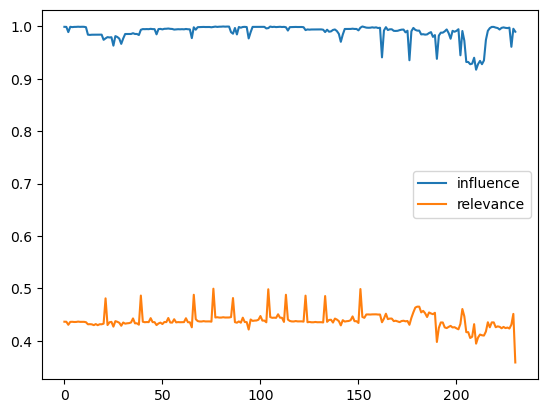

In [ ]:
# visualize the influence and relevance score
import matplotlib.pyplot as plt


influence = [item['influence'] for item in competence]
relevance = [item['relevance'] for item in competence]

# line chart
plt.plot(influence, label='influence')
plt.plot(relevance, label='relevance')
plt.legend()
plt.show()